In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Read csv by Using Pandas**

In [2]:
dataframe = pd.read_csv("./heart.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


**Preprocessing**

In [3]:
dataframe["target"] = dataframe["target"].replace(0, -1)
dataframe.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
610,43,0,0,132,341,1,0,136,1,3.0,1,0,3,-1
982,67,0,0,106,223,0,1,142,0,0.3,2,2,2,1
839,51,1,0,140,261,0,0,186,1,0.0,2,0,2,1
867,41,1,1,110,235,0,1,153,0,0.0,2,0,2,1
906,42,1,0,140,226,0,1,178,0,0.0,2,0,2,1


In [4]:
def train_test_split(features, labels, test_size = 0.25, random_state = np.random.randint(100)):
    train_size = int(np.round((1 - test_size) * features.shape[0]))
    np.random.seed(random_state)
    new_features = np.random.permutation(features)
    np.random.seed(random_state)
    new_labels = np.random.permutation(labels)
    
    features_train = new_features[:train_size]
    labels_train = new_labels[:train_size]
    features_test = new_features[train_size:]
    labels_test = new_labels[train_size:]
    
    return features_train, features_test, labels_train, labels_test
    

In [5]:
features = np.array(dataframe.drop(columns="target"))
labels = np.array(dataframe["target"])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=40)

---

**Support Vector Machine Algorithm**

In [6]:
# Support Vector Machine classifiers by kernel which is linear.
class SVM:
    def __init__(self, learning_rate=1, gamma=1):
        self.learning_rate = learning_rate
        self.gamma = gamma
    
    def fit(self, features_train, labels_train):
        
        #store info
        self.d = features_train.shape[1]
        self.n_record = features_train.shape[0]
        
        # set up features and labels
        full_one = np.ones((self.n_record, 1))
        self.features = np.append(features_train, full_one, axis=1)
        self.labels = labels_train

        # set vector of weight by d dimensions
        self.weight = np.zeros(self.d + 1)
        self.array_weight = np.empty((0, self.d+1), float)
        
        for i in range(1000):
            self.weight = self.computeWeight(self.weight, self.features, self.labels, self.n_record) # compute to get weight's value
            
            self.array_weight = np.append(self.array_weight, [self.weight], axis=0)

        
    def computeWeight(self, weight, feature_train, labels_train, n_record):
        new_weight = weight
        for i in range(n_record):
            check = labels_train[i] * (np.inner(new_weight, feature_train[i]))
            if check < 1:
                cost = self.gamma * new_weight - np.inner(labels_train[i], feature_train[i])
                step = (-1) * self.learning_rate * cost
                new_weight += step
            else:
                cost = self.gamma * new_weight
                step = (-1) * self.learning_rate * cost
                new_weight += step      
        return new_weight
    
    def predict(self, feature_test):
        new_feature_test = np.append(feature_test, 1)
        check = np.inner(self.weight, new_feature_test)
        if check >= 0 :
            # positive class
            return 1 
        else:
            # negative class
            return -1
    
    def hinge_loss(self, weight, features, labels, size):
        sum_loss = 0
        for i in range(size):
            check = 1-labels[i] * (np.inner(weight, features[i]))
            if check > 0:
                sum_loss += check
        return sum_loss
    
    def accuracy_score(self, features_test, labels_test):
        size = features_test.shape[0]
        point = 0
        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i]:
                point += 1
        
        return np.round(point / size, 4)
    
    def get_array_loss(self, features, labels):
        array_loss = np.array([])
        full_one = np.ones((features.shape[0], 1))
        new_features = np.append(features, full_one, axis=1)
        number_weight = self.array_weight.shape[0]
        number_record = features.shape[0]
        
        for i in range(number_weight):
            loss = self.hinge_loss(self.array_weight[i], new_features, labels, number_record)
            array_loss = np.append(array_loss, loss)
        
        return array_loss
    
    def sensitivity_score(self, features_test, labels_test):
        size = features_test.shape[0]
        pointTP = 0
        pointFP = 0

        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i] and y_predict == 1:
                pointTP += 1
                
            elif y_predict == 1:
                pointFP += 1
        
        return np.round(pointTP/(pointTP + pointFP), 4)
    
    def specificity_score(self, features_test, labels_test):
        size = features_test.shape[0]
        pointTN = 0
        pointFP = 0
        
        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i] and y_predict == -1:
                pointTN += 1
            
            if y_predict != labels_test[i] and y_predict == 1:
                pointFP += 1
        
        return np.round(pointTN/(pointTN + pointFP))
            

In [7]:
model = SVM(learning_rate=0.000005, gamma=0.000001)
model.fit(features_train, labels_train)
print(model.weight)

[-3.79994996e-03 -3.12154327e-01  5.33303689e-01 -9.37995353e-03
 -3.14994479e-04 -1.24199802e-02  7.07948357e-02  1.83799104e-02
 -2.76049364e-01 -3.89351439e-01  1.58989594e-01 -4.57703893e-01
 -3.61499183e-01 -1.39599662e-02]


Accuracy of Test data

In [8]:
model.accuracy_score(features_test, labels_test)

0.8516

Accuracy of Training data

In [9]:
model.accuracy_score(features_train, labels_train)

0.8362

Sensitivity of Test data

In [10]:
model.sensitivity_score(features_test, labels_test)

0.7881

Sensitivity of Training data

In [11]:
model.sensitivity_score(features_train, labels_train)

0.8022

Specificity of Test data

In [12]:
model.specificity_score(features_test, labels_test)

1.0

Specificity of Training data

In [13]:
model.specificity_score(features_train, labels_train)

1.0

The shape of features_train and features_test

In [14]:
print(features_train.shape)
print(features_test.shape)

(769, 13)
(256, 13)


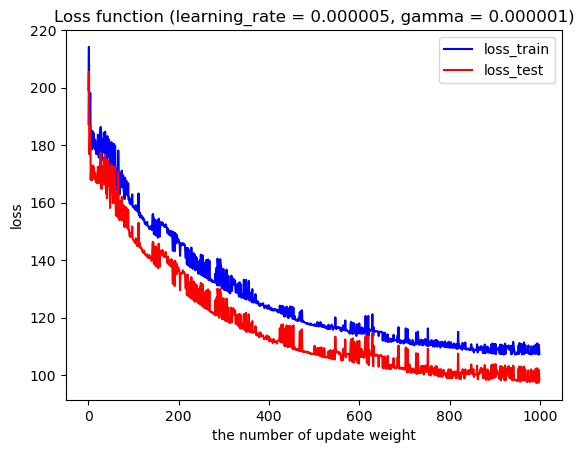

In [15]:
# plot that is loss training data
plt.plot(model.get_array_loss(features_train[0:256], labels_train[0:256]), color="b", label = "loss_train")
# plot that is loss test data
plt.plot(model.get_array_loss(features_test, labels_test), color="r", label = "loss_test")
plt.ylabel("loss")
plt.xlabel("the number of update weight")
plt.title("Loss function (learning_rate = 0.000005, gamma = 0.000001)")
plt.legend()
plt.show()

---

**Model Selection Algorithm**

In [16]:
# Model Selection by using KFold
class KFold:
    def __init__(self, features, labels , model=SVM(learning_rate=0.0000005), n_split=10):
        self.features = features
        self.labels = labels
        self.n_split = n_split
        self.model = model
        
        # prepare to store score of train dataset
        self.array_accuracy_train = np.array([])
        self.array_sensitivity_train = np.array([])
        self.array_specificity_train = np.array([])
        
        # prepare to store score of test dataset
        self.array_accuracy_test = np.array([])
        self.array_sensitivity_test = np.array([])
        self.array_specificity_test = np.array([])
        
        self.array_split = np.array([])
        
        self.size = features.shape[0]
        
        for i in range(n_split):
            start = i * int(self.size/n_split)
            end = (i + 1) * int(self.size/n_split)
            if end > self.size:
                end = self.size
            
            self.array_split = np.append(self.array_split, end-start)
            
            features_test = self.features[start:end]
            labels_test = self.labels[start:end]
            
            features_train = np.delete(self.features, slice(start, end), axis=0)
            labels_train = np.delete(self.labels, slice(start, end), axis=0)
            
            self.model.fit(features_train, labels_train)
            self.array_accuracy_test = np.append(self.array_accuracy_test, self.model.accuracy_score(features_test, labels_test))
            self.array_sensitivity_test = np.append(self.array_sensitivity_test, self.model.sensitivity_score(features_test, labels_test))
            self.array_specificity_test = np.append(self.array_specificity_test, self.model.specificity_score(features_test, labels_test))
            
            self.array_accuracy_train = np.append(self.array_accuracy_train, self.model.accuracy_score(features_train, labels_train))
            self.array_sensitivity_train = np.append(self.array_sensitivity_train, self.model.sensitivity_score(features_train, labels_train))
            self.array_specificity_train = np.append(self.array_specificity_train, self.model.specificity_score(features_train, labels_train))

    def get_mean_score_test(self, typeScore):
        match typeScore:
            case "accuracy":
                return np.round(np.mean(self.array_accuracy_test), 4)
            case "sensitivity":
                return np.round(np.mean(self.array_sensitivity_test), 4)
            case "specificity":
                return np.round(np.mean(self.array_specificity_test), 4)
            
    def get_mean_score_train(self, typeScore):
        match typeScore:
            case "accuracy":
                return np.round(np.mean(self.array_accuracy_train), 4)
            case "sensitivity":
                return np.round(np.mean(self.array_sensitivity_train), 4)
            case "specificity":
                return np.round(np.mean(self.array_specificity_train), 4)
                
    
    def get_max_score_test(self, typeScore):
        match typeScore:
            case "accuracy":
                return np.round(np.max(self.array_accuracy_test), 4)
            case "sensitivity":
                return np.round(np.max(self.array_sensitivity_test), 4)
            case "specificity":
                return np.round(np.max(self.array_specificity_test), 4)
    
    def get_max_score_train(self, typeScore):
        match typeScore:
            case "accuracy":
                return np.round(np.max(self.array_accuracy_train), 4)
            case "sensitivity":
                return np.round(np.max(self.array_sensitivity_train), 4)
            case "specificity":
                return np.round(np.max(self.array_specificity_train), 4)
    

**Parameter Of SVM For K-Fold**
$$\alpha = 0.000005, \gamma = 0.000001 $$

In [17]:
kfold = KFold(features_train, labels_train, SVM(learning_rate=0.000005, gamma=0.000001))

Score of Training data

In [18]:
print("Mean Of Accuracy Score: ", kfold.get_mean_score_train("accuracy"))
print("Mean Of Sensitivity Score: ", kfold.get_mean_score_train("sensitivity"))
print("Mean Of Specificity Score: ", kfold.get_mean_score_train("specificity"))
print("Max Of Accuracy Score: ", kfold.get_max_score_train("accuracy"))
print("Max Of Sensitivity Score: ", kfold.get_max_score_train("sensitivity"))
print("Max Of Specificity Score: ", kfold.get_max_score_train("specificity"))

Mean Of Accuracy Score:  0.8278
Mean Of Sensitivity Score:  0.8056
Mean Of Specificity Score:  1.0
Max Of Accuracy Score:  0.8427
Max Of Sensitivity Score:  0.849
Max Of Specificity Score:  1.0


Score of Test data

In [19]:
print("Mean Of Accuracy Score: ", kfold.get_mean_score_test("accuracy"))
print("Mean Of Sensitivity Score: ", kfold.get_mean_score_test("sensitivity"))
print("Mean Of Specificity Score: ", kfold.get_mean_score_test("specificity"))
print("Max Of Accuracy Score: ", kfold.get_max_score_test("accuracy"))
print("Max Of Sensitivity Score: ", kfold.get_max_score_test("sensitivity"))
print("Max Of Specificity Score: ", kfold.get_max_score_test("specificity"))

Mean Of Accuracy Score:  0.8342
Mean Of Sensitivity Score:  0.8106
Mean Of Specificity Score:  1.0
Max Of Accuracy Score:  0.9211
Max Of Sensitivity Score:  0.9302
Max Of Specificity Score:  1.0


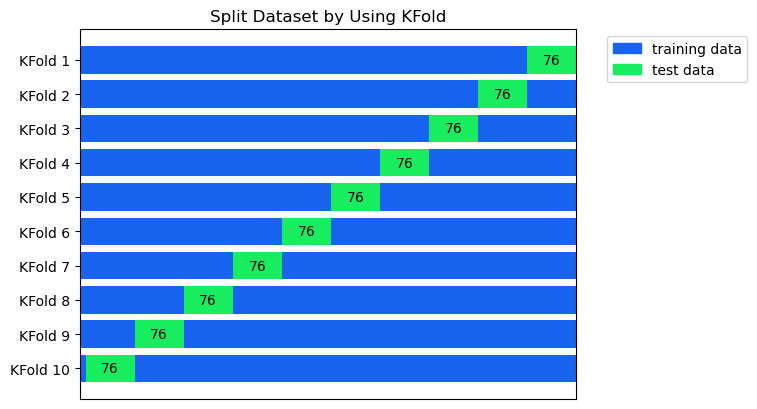

In [20]:
import matplotlib.patches as mpatches

size = kfold.size
array = np.full(10, size)
labels = [f"KFold {i+1}" for i in range(10)]
fig, axBar = plt.subplots()
axBar.invert_yaxis()
axBar.xaxis.set_visible(False)
axBar.set_xlim(size)
left = 0

plt.barh(labels, array, color="#1864F0")
for i in range(10):
    p = plt.barh(labels[i], kfold.array_split[i], color="#18ED60", left=left)
    plt.bar_label(p, label_type="center")
    left += kfold.array_split[i]

axBar.title.set_text("Split Dataset by Using KFold")
patch1 = mpatches.Patch(color="#1864F0", label="training data")
patch2 = mpatches.Patch(color="#18ED60", label="test data")
axBar.legend(handles=[patch1, patch2], loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

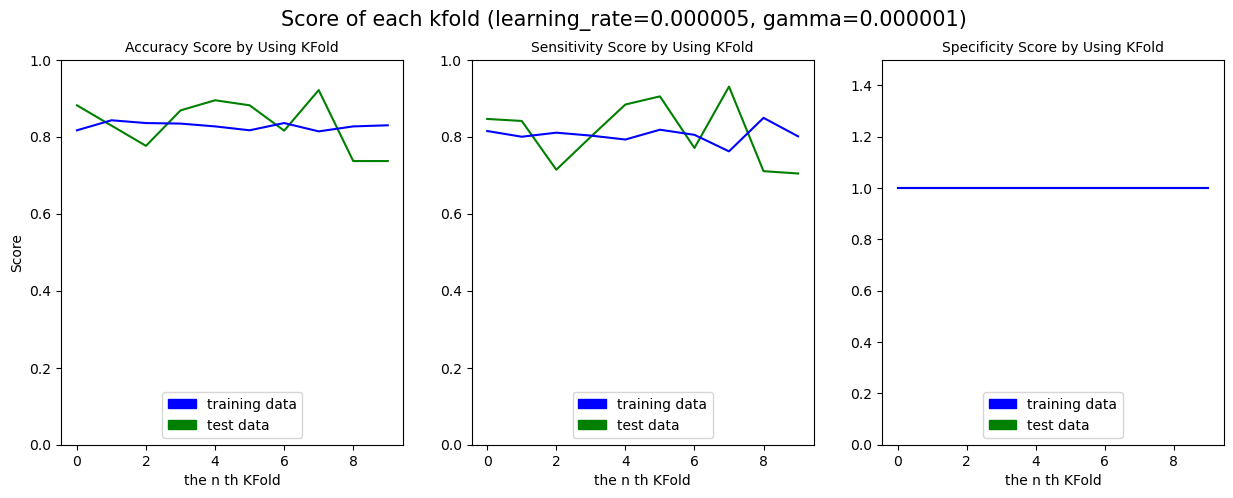

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

fig.suptitle("Score of each kfold (learning_rate=0.000005, gamma=0.000001)", fontsize=15)

ax1.plot(kfold.array_accuracy_test, color="g")
ax1.plot(kfold.array_accuracy_train, color="b")
ax1.set_title("Accuracy Score by Using KFold", fontsize=10)
ax1.set_ylabel("Score")
ax1.set_xlabel("the n th KFold")
ax1.set_ylim([0, 1])

ax2.plot(kfold.array_sensitivity_test, color="g")
ax2.plot(kfold.array_sensitivity_train, color="b")
ax2.set_title("Sensitivity Score by Using KFold", fontsize=10)
ax2.set_xlabel("the n th KFold")
ax2.set_ylim([0, 1])

ax3.plot(kfold.array_specificity_test, color="g")
ax3.plot(kfold.array_specificity_train, color="b")
ax3.set_title("Specificity Score by Using KFold", fontsize=10)
ax3.set_xlabel("the n th KFold")
ax3.set_ylim([0, 1.5])

patch1 = mpatches.Patch(color="b", label="training data")
patch2 = mpatches.Patch(color="g", label="test data")
ax1.legend(handles=[patch1, patch2], loc="lower center")
ax2.legend(handles=[patch1, patch2], loc="lower center")
ax3.legend(handles=[patch1, patch2], loc="lower center")

plt.show()

**Parameter Of SVM For K-Fold**
$$\alpha = 0.000005, \gamma = 0.001 $$

In [22]:
kfold2 = KFold(features_train, labels_train, SVM(learning_rate=0.000005, gamma=1))

Score of Training Data

In [23]:
print("Mean Of Accuracy Score: ", kfold2.get_mean_score_train("accuracy"))
print("Mean Of Sensitivity Score: ", kfold2.get_mean_score_train("sensitivity"))
print("Mean Of Specificity Score: ", kfold2.get_mean_score_train("specificity"))
print("Max Of Accuracy Score: ", kfold2.get_max_score_train("accuracy"))
print("Max Of Sensitivity Score: ", kfold2.get_max_score_train("sensitivity"))
print("Max Of Specificity Score: ", kfold2.get_max_score_train("specificity"))

Mean Of Accuracy Score:  0.7441
Mean Of Sensitivity Score:  0.7738
Mean Of Specificity Score:  1.0
Max Of Accuracy Score:  0.7561
Max Of Sensitivity Score:  0.8282
Max Of Specificity Score:  1.0


Score of Test Data

In [24]:
print("Mean Of Accuracy Score: ", kfold2.get_mean_score_test("accuracy"))
print("Mean Of Sensitivity Score: ", kfold2.get_mean_score_test("sensitivity"))
print("Mean Of Specificity Score: ", kfold2.get_mean_score_test("specificity"))
print("Max Of Accuracy Score: ", kfold2.get_max_score_test("accuracy"))
print("Max Of Sensitivity Score: ", kfold2.get_max_score_test("sensitivity"))
print("Max Of Specificity Score: ", kfold2.get_max_score_test("specificity"))

Mean Of Accuracy Score:  0.7355
Mean Of Sensitivity Score:  0.7688
Mean Of Specificity Score:  1.0
Max Of Accuracy Score:  0.8026
Max Of Sensitivity Score:  0.9
Max Of Specificity Score:  1.0


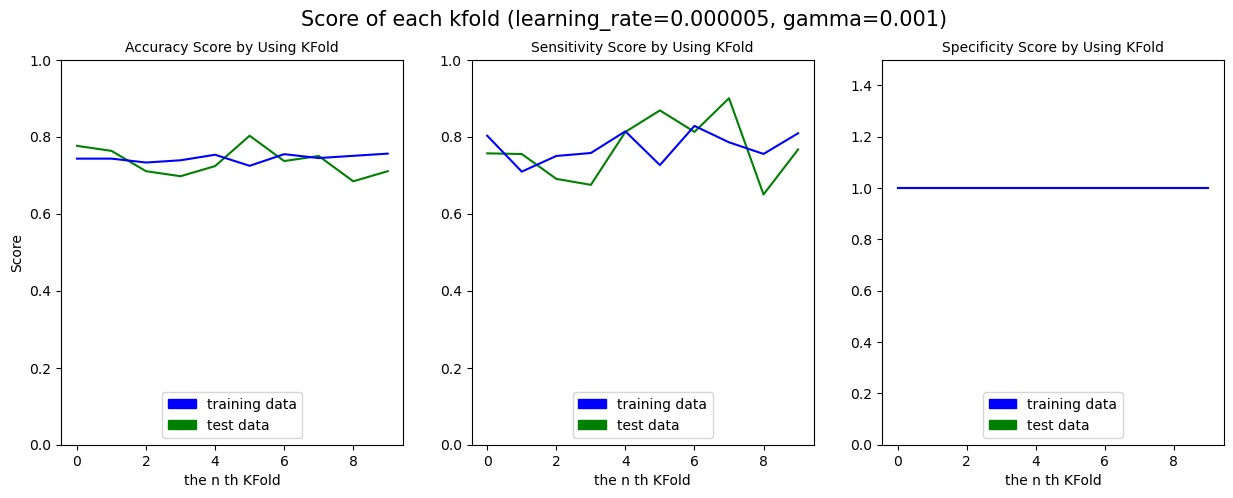

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

fig.suptitle("Score of each kfold (learning_rate=0.000005, gamma=0.001)", fontsize=15)

ax1.plot(kfold2.array_accuracy_test, color="g")
ax1.plot(kfold2.array_accuracy_train, color="b")
ax1.set_title("Accuracy Score by Using KFold", fontsize=10)
ax1.set_ylabel("Score")
ax1.set_xlabel("the n th KFold")
ax1.set_ylim([0, 1])

ax2.plot(kfold2.array_sensitivity_test, color="g")
ax2.plot(kfold2.array_sensitivity_train, color="b")
ax2.set_title("Sensitivity Score by Using KFold", fontsize=10)
ax2.set_xlabel("the n th KFold")
ax2.set_ylim([0, 1])

ax3.plot(kfold2.array_specificity_test, color="g")
ax3.plot(kfold2.array_specificity_train, color="b")
ax3.set_title("Specificity Score by Using KFold", fontsize=10)
ax3.set_xlabel("the n th KFold")
ax3.set_ylim([0, 1.5])

patch1 = mpatches.Patch(color="b", label="training data")
patch2 = mpatches.Patch(color="g", label="test data")
ax1.legend(handles=[patch1, patch2], loc="lower center")
ax2.legend(handles=[patch1, patch2], loc="lower center")
ax3.legend(handles=[patch1, patch2], loc="lower center")

plt.show()

---